In [1]:
# base imports
import numpy as np
import os
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

# make output stable across multiple runs
np.random.seed(42)

In [2]:
# building a 3D dataset
np.random.seed(4)
m = 60
w1, w2 = 0.1, 0.3
noise = 0.1

angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
X = np.empty((m, 3))
X[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m)/2
X[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m)/2
X[:, 2] = X[:, 0] * w1 + X[:, 1] * w2 + noise * np.random.randn(m)

In [3]:
# principal component analysis (PCA) and SVD decomposition
X_centered = X - X.mean(axis=0)
U, s, Vt = np.linalg.svd(X_centered)
c1 = Vt.T[:, 0]
c2 = Vt.T[:, 1]

In [4]:
m, n = X.shape

S = np.zeros(X_centered.shape)
S[:n, :n] = np.diag(s)

In [5]:
np.allclose(X_centered, U.dot(S).dot(Vt))

True

In [6]:
W2 = Vt.T[:, :2]
X2D = X_centered.dot(W2)

In [7]:
X2D_using_svd = X2D

In [8]:
# PCD w/ scikit
from sklearn.decomposition import PCA

pca = PCA(n_components = 2)
X2D = pca.fit_transform(X)

In [9]:
X2D[:5]

array([[ 1.26203346,  0.42067648],
       [-0.08001485, -0.35272239],
       [ 1.17545763,  0.36085729],
       [ 0.89305601, -0.30862856],
       [ 0.73016287, -0.25404049]])

In [10]:
X2D_using_svd[:5]

array([[-1.26203346, -0.42067648],
       [ 0.08001485,  0.35272239],
       [-1.17545763, -0.36085729],
       [-0.89305601,  0.30862856],
       [-0.73016287,  0.25404049]])

In [11]:
# running PCA multiple times on slightly different datasets
# may produce different results
# generally the only difference is the axes may be flipped
# PCA w/ scikit gives same projection as one with SVD approach
# except both of the axes are flipped
np.allclose(X2D, -X2D_using_svd)

True

In [12]:
# recover 3D points projected on plane
X3D_inv = pca.inverse_transform(X2D)

In [13]:
# due to information loss from projection step
# recovered 3D points are not exactly equal to original 3D points
np.allclose(X3D_inv, X)

False

In [14]:
# compute reconstruction error
np.mean(np.sum(np.square(X3D_inv - X), axis=1))

0.010170337792848549

In [15]:
# inverse transform in svd approach
X3D_inv_using_svd = X2D_using_svd.dot(Vt[:2, :])

In [16]:
# reconstructions from both methods are not identical
# skikit's PCA automatically takes care of reversing the mean centering
# subtracting the mean will give same result
np.allclose(X3D_inv_using_svd, X3D_inv - pca.mean_)

True

In [17]:
# PCA object gives access to principal components that it computed
pca.components_

array([[-0.93636116, -0.29854881, -0.18465208],
       [ 0.34027485, -0.90119108, -0.2684542 ]])

In [18]:
# compare first two principal components computed w/ svd method
Vt[:2]
# axes are flipped

array([[ 0.93636116,  0.29854881,  0.18465208],
       [-0.34027485,  0.90119108,  0.2684542 ]])

In [19]:
# explained variance ratio
pca.explained_variance_ratio_
# first dimension explains 84.2% of variance, 14.6% by the second

array([0.84248607, 0.14631839])

In [20]:
# projecting down to 2D results in 1.1% of variance loss
1 - pca.explained_variance_ratio_.sum()

0.011195535570688975

In [21]:
# computing variance ratio w/ svd method
np.square(s) / np.square(s).sum()

array([0.84248607, 0.14631839, 0.01119554])

In [22]:
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d

class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0, 0), (0, 0), *args, **kwargs)
        self._verts3d = xs, ys, zs
        
    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0], ys[0]), (xs[1], ys[1]))
        FancyArrowPatch.draw(self, renderer)

In [23]:
# plane as f(x, y)
axes = [-1.8, 1.8, -1.3, 1.3, -1.0, 1.0]

x1s = np.linspace(axes[0], axes[1], 10)
x2s = np.linspace(axes[2], axes[3], 10)
x1, x2 = np.meshgrid(x1s, x2s)

C = pca.components_
R = C.T.dot(C)
z = (R[0, 2] * x1 + R[1, 2] * x2) / (1 - R[2, 2])

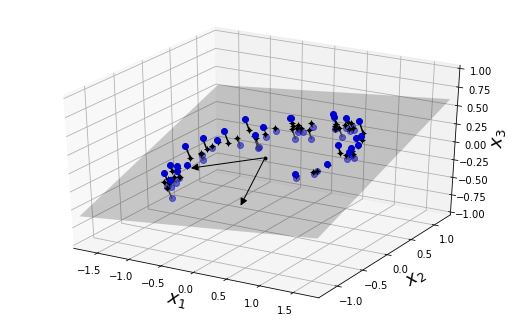

In [24]:
# plot
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(9, 5.7))
ax = fig.add_subplot(111, projection='3d')

X3D_above = X[X[:, 2] > X3D_inv[:, 2]]
X3D_below = X[X[:, 2] <= X3D_inv[:, 2]]

ax.plot(X3D_below[:, 0], X3D_below[:, 1], X3D_below[:, 2], 'bo', alpha=0.5)

ax.plot_surface(x1, x2, z, alpha=0.2, color='k')
np.linalg.norm(C, axis=0)
ax.add_artist(Arrow3D([0, C[0, 0]], [0, C[0, 1]], [0, C[0, 2]], 
                     mutation_scale=15, lw=1, arrowstyle='-|>', color='k'))
ax.add_artist(Arrow3D([0, C[1, 0]], [0, C[1, 1]], [0, C[1, 2]],
                     mutation_scale=15, lw=1, arrowstyle='-|>', color='k'))
ax.plot([0], [0], [0], 'k.')

for i in range(m):
    if X[i, 2] > X3D_inv[i, 2]:
        ax.plot([X[i][0], X3D_inv[i][0]], [X[i][1], X3D_inv[i][1]], [X[i][2], X3D_inv[i][2]], 'k-')
    else:
        ax.plot([X[i][0], X3D_inv[i][0]], [X[i][1], X3D_inv[i][1]], [X[i][2], X3D_inv[i][2]], 'k-', color='#505050')
        
ax.plot(X3D_inv[:, 0], X3D_inv[:, 1], X3D_inv[:, 2], 'k+')
ax.plot(X3D_inv[:, 0], X3D_inv[:, 1], X3D_inv[:, 2], 'k.')
ax.plot(X3D_above[:, 0], X3D_above[:, 1], X3D_above[:, 2], 'bo')
ax.set_xlabel('$x_1$', fontsize=18)
ax.set_ylabel('$x_2$', fontsize=18)
ax.set_zlabel('$x_3$', fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

plt.show()

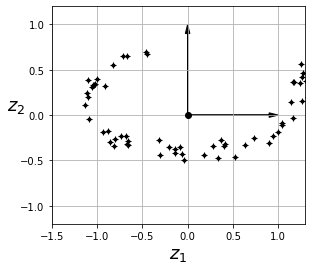

In [25]:
# project every training instance perpendicularly onto the subspace
fig = plt.figure()
ax = fig.add_subplot(111, aspect='equal')

ax.plot(X2D[:, 0], X2D[:, 1], 'k+')
ax.plot(X2D[:, 0], X2D[:, 1], 'k.')
ax.plot([0], [0], 'ko')
ax.arrow(0, 0, 0, 1, head_width=0.05, length_includes_head=True, head_length=0.1, fc='k', ec='k')
ax.arrow(0, 0, 1, 0, head_width=0.05, length_includes_head=True, head_length=0.1, fc='k', ec='k')
ax.set_xlabel('$z_1$', fontsize=18)
ax.set_ylabel('$z_2$', fontsize=18, rotation=0)
ax.axis([-1.5, 1.3, -1.2, 1.2])
ax.grid(True)

plt.show()
# dimensionality reduced from 3D to 2D

In [26]:
# projection now always the best approach to reducing dimensionality
# swiss roll dataset is good example of this
from sklearn.datasets import make_swiss_roll
X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)

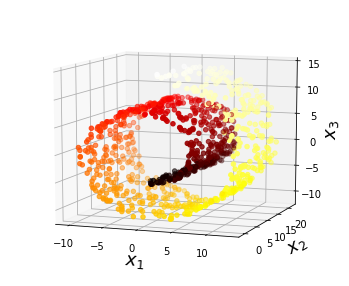

In [27]:
# making swiss roll
axes = [-11.5, 14, -2, 23, -12, 15]

fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=t, cmap=plt.cm.hot)
ax.view_init(10, -70)
ax.set_xlabel('$x_1$', fontsize=18)
ax.set_ylabel('$x_2$', fontsize=18)
ax.set_zlabel('$x_3$', fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

plt.show()

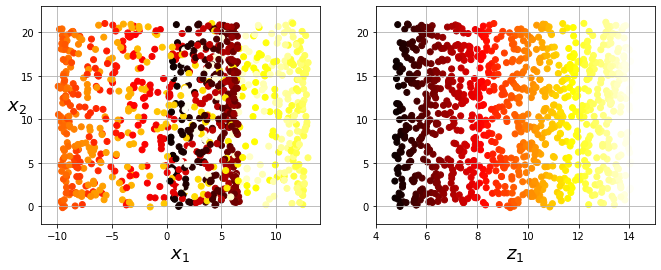

In [28]:
# simply projecting onto the plane would make the left plot
# which squashes all the layers together
# ideally you would need to unroll the swiss roll
# to get a good 2D data set, such as the right plot
plt.figure(figsize=(11, 4))

plt.subplot(121)
plt.scatter(X[:, 0], X[:, 1], c=t, cmap=plt.cm.hot)
plt.axis(axes[:4])
plt.xlabel('$x_1$', fontsize=18)
plt.ylabel('$x_2$', fontsize=18, rotation=0)
plt.grid(True)

plt.subplot(122)
plt.scatter(t, X[:, 1], c=t, cmap=plt.cm.hot)
plt.axis([4, 15, axes[2], axes[3]])
plt.xlabel('$z_1$', fontsize=18)
plt.grid(True)

plt.show()

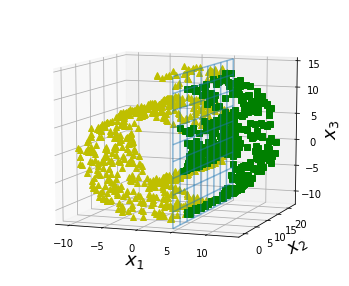

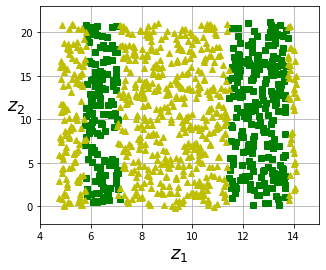

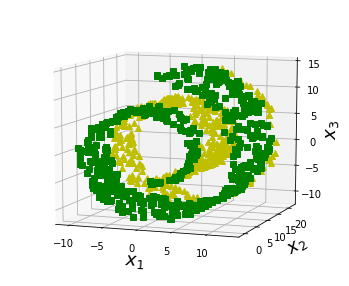

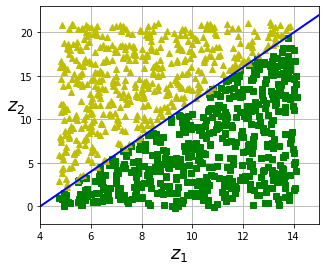

In [29]:
# manifold learning
# manifold assumption/hypothesis: most real-world high-dimensional datasets
# lie close to a much lower-dimensional manifold
# often accompanied by another implicit assumption:
# the task at hand will be simpler if expressed in the lower-dimensional
# space of the manifold
from matplotlib import gridspec

axes = [-11.5, 14, -2, 23, -12, 15]

x2s = np.linspace(axes[2], axes[3], 10)
x3s = np.linspace(axes[4], axes[5], 10)
x2, x3 = np.meshgrid(x2s, x3s)

# assumption does not hold for the following:
# decision boundary at x1=5 in 3D space is a vertical plane
# however decision boundary in unrolled manifold is collection of 4 segments

fig = plt.figure(figsize=(6, 5))
ax = plt.subplot(111, projection='3d')

positive_class = X[:, 0] > 5
X_pos = X[positive_class]
X_neg = X[~positive_class]
ax.view_init(10, -70)
ax.plot(X_neg[:, 0], X_neg[:, 1], X_neg[:, 2], 'y^')
ax.plot_wireframe(5, x2, x3, alpha=0.5)
ax.plot(X_pos[:, 0], X_pos[:, 1], X_pos[:, 2], 'gs')
ax.set_xlabel('$x_1$', fontsize=18)
ax.set_ylabel('$x_2$', fontsize=18)
ax.set_zlabel('$x_3$', fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

# 2D unrolled manifold decision boundary

fig = plt.figure(figsize=(5, 4))
ax = plt.subplot(111)

plt.plot(t[positive_class], X[positive_class, 1], 'gs')
plt.plot(t[~positive_class], X[~positive_class, 1], 'y^')
plt.axis([4, 15, axes[2], axes[3]])
plt.xlabel('$z_1$', fontsize=18)
plt.ylabel('$z_2$', fontsize=18, rotation=0)
plt.grid(True)

# assumption holds true for the following:
# the decision boundary in the 3D plot would be quite complex
# but 2D unrolled manifold decision boundary is a straight line

fig = plt.figure(figsize=(6, 5))
ax = plt.subplot(111, projection='3d')

positive_class = 2 * (t[:] - 4) > X[:, 1]
X_pos = X[positive_class]
X_neg = X[~positive_class]
ax.view_init(10, -70)
ax.plot(X_neg[:, 0], X_neg[:, 1], X_neg[:, 2], 'y^')
ax.plot(X_pos[:, 0], X_pos[:, 1], X_pos[:, 2], 'gs')
ax.set_xlabel('$x_1$', fontsize=18)
ax.set_ylabel('$x_2$', fontsize=18)
ax.set_zlabel('$x_3$', fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

# 2D unrolled manifold decision boundary

fig = plt.figure(figsize=(5, 4))
ax = plt.subplot(111)

plt.plot(t[positive_class], X[positive_class, 1], 'gs')
plt.plot(t[~positive_class], X[~positive_class, 1], 'y^')
plt.plot([4, 15], [0, 22], 'b-', linewidth=2)
plt.axis([4, 15, axes[2], axes[3]])
plt.xlabel('$z_1$', fontsize=18)
plt.ylabel('$z_2$', fontsize=18, rotation=0)
plt.grid(True)

plt.show()

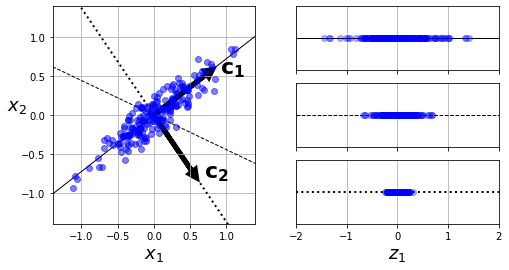

In [30]:
# PCA is most popular dimensionality reduction algorithm
# it identifies the hyperplane that lies closest to the data
# then projects the data onto it
angle = np.pi / 5
stretch = 5
m = 200

np.random.seed(3)
X = np.random.randn(m, 2) / 10
X = X.dot(np.array([[stretch, 0], [0, 1]])) # stretch
X = X.dot([[np.cos(angle), np.sin(angle)], [-np.sin(angle), np.cos(angle)]]) # rotate

u1 = np.array([np.cos(angle), np.sin(angle)])
u2 = np.array([np.cos(angle - 2 * np.pi/6), np.sin(angle - 2 * np.pi/6)])
u3 = np.array([np.cos(angle - np.pi/2), np.sin(angle - np.pi/2)])

X_proj1 = X.dot(u1.reshape(-1, 1))
X_proj2 = X.dot(u2.reshape(-1, 1))
X_proj3 = X.dot(u3.reshape(-1, 1))

plt.figure(figsize=(8, 4))
plt.subplot2grid((3, 2), (0, 0), rowspan=3)
plt.plot([-1.4, 1.4], [-1.4*u1[1]/u1[0], 1.4*u1[1]/u1[0]], 'k-', linewidth=1)
plt.plot([-1.4, 1.4], [-1.4*u2[1]/u2[0], 1.4*u2[1]/u2[0]], 'k--', linewidth=1)
plt.plot([-1.4, 1.4], [-1.4*u3[1]/u3[0], 1.4*u3[1]/u3[0]], 'k:', linewidth=2)
plt.plot(X[:, 0], X[:, 1], 'bo', alpha=0.5)
plt.axis([-1.4, 1.4, -1.4, 1.4])
plt.arrow(0, 0, u1[0], u1[1], head_width=0.1, linewidth=5, 
         length_includes_head=True, head_length=0.1, fc='k', ec='k')
plt.arrow(0, 0, u3[0], u3[1], head_width=0.1, linewidth=5,
         length_includes_head=True, head_length=0.1, fc='k', ec='k')
plt.text(u1[0] + 0.1, u1[1] - 0.05, r'$\mathbf{c_1}$', fontsize=22)
plt.text(u3[0] + 0.1, u3[1], r'$\mathbf{c_2}$', fontsize=22)
plt.xlabel('$x_1$', fontsize=18)
plt.ylabel('$x_2$', fontsize=18, rotation=0)
plt.grid(True)

plt.subplot2grid((3, 2), (0, 1))
plt.plot([-2, 2], [0, 0], 'k-', linewidth=1)
plt.plot(X_proj1[:, 0], np.zeros(m), 'bo', alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.gca().get_xaxis().set_ticklabels([])
plt.axis([-2, 2, -1, 1])
plt.grid(True)

plt.subplot2grid((3, 2), (1, 1))
plt.plot([-2, 2], [0, 0], 'k--', linewidth=1)
plt.plot(X_proj2[:, 0], np.zeros(m), 'bo', alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.gca().get_xaxis().set_ticklabels([])
plt.axis([-2, 2, -1, 1])
plt.grid(True)

plt.subplot2grid((3, 2), (2, 1))
plt.plot([-2, 2], [0, 0], 'k:', linewidth=2)
plt.plot(X_proj3[:, 0], np.zeros(m), 'bo', alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.axis([-2, 2, -1, 1])
plt.xlabel('$z_1$', fontsize=18)
plt.grid(True)

plt.show()
# select the subspace to project on that preserves the max amount of variance
# this makes sure it loses the least amount of information
# plot shows 2D dataset projecting on each axis
# projection on the solid line preserves the max amount of variance
# projection on dotted line preserves the least amount of variance

In [31]:
# compression
from six.moves import urllib
try:
    from sklearn.datasets import fetch_openml
    mnist = fetch_openml('mnist_784', version=1)
    mnist.target = mnist.target.astype(np.int64)
except ImportError:
    from sklearn.datasets import fetch_mldata
    mnist = fetch_mldata('MNIST original')

In [32]:
from sklearn.model_selection import train_test_split

X = mnist['data']
y = mnist['target']

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [33]:
pca = PCA()
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1

In [34]:
d

154

In [35]:
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X_train)

In [36]:
pca.n_components_

154

In [37]:
np.sum(pca.explained_variance_ratio_)

0.9504334914295707

In [38]:
# compress MNIST dataset to 154 dimensions
# decompress back to 784 dimensions
pca = PCA(n_components=154)
X_reduced = pca.fit_transform(X_train)
X_recovered = pca.inverse_transform(X_reduced)

In [39]:
def plot_digits(instances, images_per_row=5, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size, size) for instance in instances]
    n_rows = (len(instances) - 1) //  images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis('off')

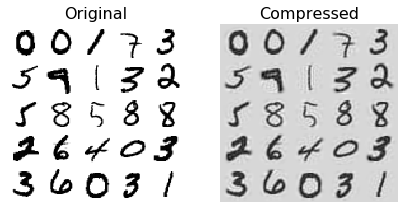

In [40]:
# original training set on left
# same set compressed and decompressed on right
# slight loss of image quality but digits remain mostly intact
# 95% of the variance is preserved
plt.figure(figsize=(7, 4))

plt.subplot(121)
plot_digits(X_train[::2100])
plt.title('Original', fontsize=16)

plt.subplot(122)
plot_digits(X_recovered[::2100])
plt.title('Compressed', fontsize=16)

plt.show()

In [41]:
X_reduced_pca = X_reduced

In [42]:
# incremental PCA
# splits training set into mini-batches and feed an IPCA algorithm
# one mini-batch at a time

# split dataset into 100 mini-batches and feed them into IPCA class
# reduces the dimensionality of dataset to 154 dimensions
from sklearn.decomposition import IncrementalPCA

n_batches = 100
inc_pca = IncrementalPCA(n_components=154)
for X_batch in np.array_split(X_train, n_batches):
    print('.', end='')
    inc_pca.partial_fit(X_batch)
    
X_reduced = inc_pca.transform(X_train)

....................................................................................................

In [43]:
X_recovered_inc_pca = inc_pca.inverse_transform(X_reduced)

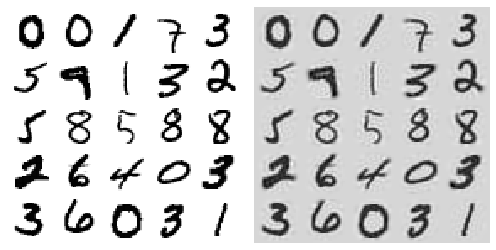

In [44]:
plt.figure(figsize=(7, 4))

plt.subplot(121)
plot_digits(X_train[::2100])

plt.subplot(122)
plot_digits(X_recovered_inc_pca[::2100])
plt.tight_layout()

plt.show()

In [45]:
X_reduced_inc_pca = X_reduced

In [46]:
# compare results of transforming MNIST using regular PCA and IPCA
# means are equal
np.allclose(pca.mean_, inc_pca.mean_)

True

In [47]:
# results not exactly identical, IPCA gives good approximate solution
# but not perfect
np.allclose(X_reduced, X_reduced_inc_pca)

True

In [48]:
# using memmap()
# manipulates a large array stored in a binary file on disk
# as if it were entirely in memory
# only loads data it needs in memory when it needs it
filename = 'my_mnist.data'
m, n = X_train.shape

X_mm = np.memmap(filename, dtype='float32', mode='write', shape=(m, n))
X_mm[:] = X_train

In [49]:
# deleting the memmap object will trigger its Python finalizer
# this ensures the data is saved to disk
del X_mm

In [50]:
# load data and train
X_mm = np.memmap(filename, dtype='float32', mode='readonly', shape=(m, n))

batch_size = m // n_batches
inc_pca = IncrementalPCA(n_components=154, batch_size=batch_size)
inc_pca.fit(X_mm)

IncrementalPCA(batch_size=525, copy=True, n_components=154, whiten=False)

In [51]:
rnd_pca = PCA(n_components=154, svd_solver='randomized', random_state=42)
X_reduced = rnd_pca.fit_transform(X_train)

In [52]:
# time complexity
# PCA vs IPCA vs Randomized PCA
import time

for n_components in (2, 10, 154):
    print('n_components = ', n_components)
    regular_pca = PCA(n_components=n_components)
    inc_pca = IncrementalPCA(n_components=n_components, batch_size=500)
    rnd_pca = PCA(n_components=n_components, random_state=42, svd_solver='randomized')
    
    for pca in (regular_pca, inc_pca, rnd_pca):
        t1 = time.time()
        pca.fit(X_train)
        t2 = time.time()
        print('    {}: {:.1f} seconds'.format(pca.__class__.__name__, t2 - t1))

n_components =  2
    PCA: 1.4 seconds
    IncrementalPCA: 39.3 seconds
    PCA: 1.4 seconds
n_components =  10
    PCA: 1.6 seconds
    IncrementalPCA: 40.5 seconds
    PCA: 1.6 seconds
n_components =  154
    PCA: 4.3 seconds
    IncrementalPCA: 51.3 seconds
    PCA: 4.3 seconds


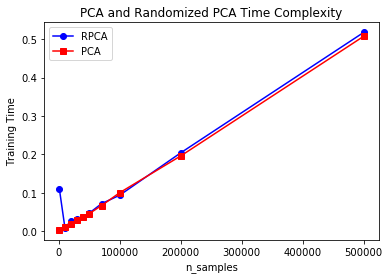

In [53]:
# compare PCA and randomized PCA for datasets of different sizes
times_rpca = []
times_pca = []
sizes = [1000, 10000, 20000, 30000, 40000, 50000, 70000, 100000, 200000, 500000]
for n_samples in sizes:
    X = np.random.randn(n_samples, 5)
    pca = PCA(n_components=2, svd_solver='randomized', random_state=42)
    t1 = time.time()
    pca.fit(X)
    t2 = time.time()
    times_rpca.append(t2 - t1)
    pca = PCA(n_components = 2)
    t1 = time.time()
    pca.fit(X)
    t2 = time.time()
    times_pca.append(t2 - t1)
    
plt.plot(sizes, times_rpca, 'b-o', label='RPCA')
plt.plot(sizes, times_pca, 'r-s', label='PCA')
plt.xlabel('n_samples')
plt.ylabel('Training Time')
plt.legend(loc='upper left')
plt.title('PCA and Randomized PCA Time Complexity')

plt.show()

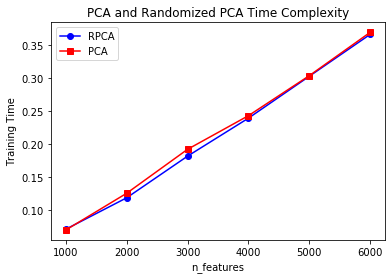

In [54]:
# compare performance on datasets of 2000 instances w/ various number of features
times_rpca = []
times_pca = []
sizes = [1000, 2000, 3000, 4000, 5000, 6000]
for n_features in sizes:
    X = np.random.randn(2000, n_features)
    pca = PCA(n_components=2, random_state=42, svd_solver='randomized')
    t1 = time.time()
    pca.fit(X)
    t2 = time.time()
    times_rpca.append(t2 - t1)
    pca = PCA(n_components = 2)
    t1 = time.time()
    pca.fit(X)
    t2 = time.time()
    times_pca.append(t2 - t1)
    
plt.plot(sizes, times_rpca, 'b-o', label='RPCA')
plt.plot(sizes, times_pca, 'r-s', label='PCA')
plt.xlabel('n_features')
plt.ylabel('Training Time')
plt.legend(loc='upper left')
plt.title('PCA and Randomized PCA Time Complexity')

plt.show()

In [55]:
# kernel PCA (kPCA)
# makes it possible to perform complex nonlinear projections
# dimensionality reduction
# good at preserving clusters of instances after projection
# sometimes even unrolling datasets that lie close to a twisted manifold
X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)

In [56]:
from sklearn.decomposition import KernelPCA

rbf_pca = KernelPCA(n_components=2, kernel='rbf', gamma=0.04)
X_reduced = rbf_pca.fit_transform(X)

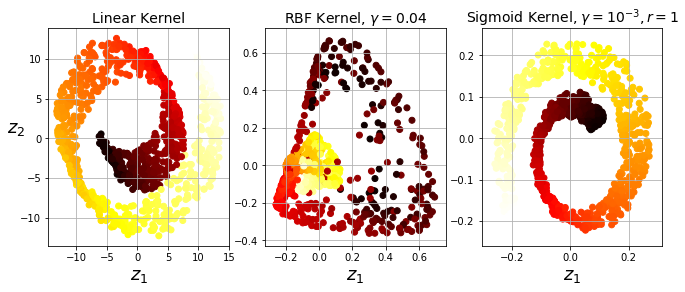

In [57]:
# swiss roll reduced to 2D using kPCA w/ various kernels
lin_pca = KernelPCA(n_components=2, kernel='linear', fit_inverse_transform=True)
rbf_pca = KernelPCA(n_components=2, kernel='rbf', gamma=0.0433, fit_inverse_transform=True)
sig_pca = KernelPCA(n_components=2, kernel='sigmoid', gamma=0.001, coef0=1, fit_inverse_transform=True)

y = t > 6.9

plt.figure(figsize=(11, 4))
for subplot, pca, title in ((131, lin_pca, 'Linear Kernel'), 
                            (132, rbf_pca, 'RBF Kernel, $\gamma=0.04$'), 
                            (133, sig_pca, 'Sigmoid Kernel, $\gamma=10^{-3}, r=1$')):
    X_reduced = pca.fit_transform(X)
    if subplot == 132:
        X_reduced_rbf = X_reduced
        
    plt.subplot(subplot)
    plt.title(title, fontsize=14)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
    plt.xlabel('$z_1$', fontsize=18)
    if subplot == 131:
        plt.ylabel('$z_2$', fontsize=18, rotation=0)
    plt.grid(True)
    
plt.show()

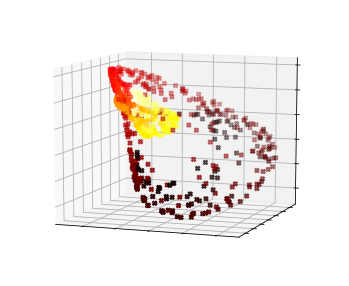

In [58]:
plt.figure(figsize=(6, 5))

X_inverse = rbf_pca.inverse_transform(X_reduced_rbf)

ax = plt.subplot(111, projection='3d')
ax.view_init(10, -70)
ax.scatter(X_inverse[:, 0], X_inverse[:, 1], X_inverse[:, 2], 
           c=t, cmap=plt.cm.hot, marker='X')
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_zlabel('')
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])

plt.show()

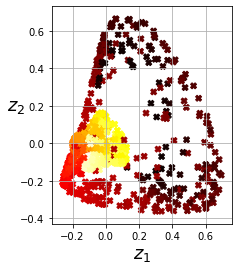

In [59]:
X_reduced = rbf_pca.fit_transform(X)

plt.figure(figsize=(11, 4))
plt.subplot(132)
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot, marker='X')
plt.xlabel('$z_1$', fontsize=18)
plt.ylabel('$z_2$', fontsize=18, rotation=0)
plt.grid(True)

In [60]:
# use grid search to select kernel and hyperparameters that lead 
# to best performance
# two-step pipeline: reducing dimensionality to 2D w/ kPCA
# then applying logisitic regression for classification
# then use grid search to find best kernel and gamma value for kPCA
# to get best classication accuracy
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

clf = Pipeline([
    ('kpca', KernelPCA(n_components=2)),
    ('log_reg', LogisticRegression(solver='liblinear'))
])

param_grid = [{
    'kpca__gamma': np.linspace(0.03, 0.05, 10),
    'kpca__kernel': ['rbf', 'sigmoid']
}]

grid_search = GridSearchCV(clf, param_grid, cv=3)
grid_search.fit(X, y)

GridSearchCV(cv=3, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('kpca',
                                        KernelPCA(alpha=1.0, coef0=1,
                                                  copy_X=True, degree=3,
                                                  eigen_solver='auto',
                                                  fit_inverse_transform=False,
                                                  gamma=None, kernel='linear',
                                                  kernel_params=None,
                                                  max_iter=None, n_components=2,
                                                  n_jobs=None,
                                                  random_state=None,
                                                  remove_zero_eig=False,
                                                  tol=0)),
                                       ('log_reg',
                                 

In [61]:
grid_search.best_params_

{'kpca__gamma': 0.043333333333333335, 'kpca__kernel': 'rbf'}

In [62]:
rbf_pca = KernelPCA(n_components=2, kernel='rbf', gamma=0.0433,
                   fit_inverse_transform=True)
X_reduced = rbf_pca.fit_transform(X)
X_preimage = rbf_pca.inverse_transform(X_reduced)

In [63]:
from sklearn.metrics import mean_squared_error

mean_squared_error(X, X_preimage)

32.78630879576618

In [64]:
# Locally Linear Embedding (LLE) another powerful
# nonlinear dimensionality reduction (NLDR) technique
# Manifold Learning technique that doesn't rely on projections
# works by first measuring how each training instance linearly relates
# to its closest neighbors
# then looking for a low-dimensional representation of the training set
# where these relationships are best preserved
X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=41)

In [65]:
from sklearn.manifold import LocallyLinearEmbedding

lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10, random_state=42)
X_reduced = lle.fit_transform(X)

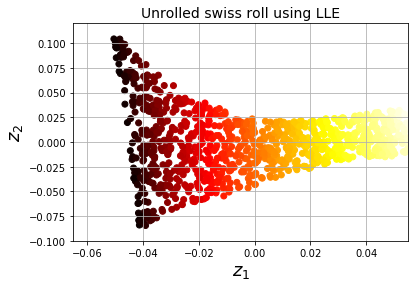

In [66]:
plt.title('Unrolled swiss roll using LLE', fontsize=14)
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
plt.xlabel('$z_1$', fontsize=18)
plt.ylabel('$z_2$', fontsize=18)
plt.axis([-0.065, 0.055, -0.1, 0.12])
plt.grid(True)

plt.show()
# good at unrolling twisted manifolds with little noise
# scales poorly to very large datasets

In [67]:
# Multidimensional Scaling (MDS) reduces dimensionality while trying to preserve
# the distances between instances
from sklearn.manifold import MDS

mds = MDS(n_components=2, random_state=42)
X_reduced_mds = mds.fit_transform(X)

In [68]:
# Isomap creates a graph connecting each instance to nearest neighbors
# reduces dimensionality while preserving geodesic distances
from sklearn.manifold import Isomap

isomap = Isomap(n_components=2)
X_reduced_isomap = isomap.fit_transform(X)

In [69]:
# t-Distributed Stochastic Neighbor Embedding (t-SNE)
# reduces dimensionality whilst keeping similar instances close and
# dissimilar instances apart
# used mostly for visualization, like clusters of instances
# in high dimensional space
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
X_reduced_tsne = tsne.fit_transform(X)

In [70]:
# Linear Discriminant Analysis (LDA)
# classification algorithm, during training it learns most discriminative axes
# between the classes
# axes can be used to define hyperplane to project the data
# benefit: projection keeps classes as far as possible
# good at reducing dimensionality before running another classification algorithm
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis(n_components=2)
X_mnist = mnist['data']
y_mnist = mnist['target']
lda.fit(X_mnist, y_mnist)
X_reduced_lda = lda.transform(X_mnist)

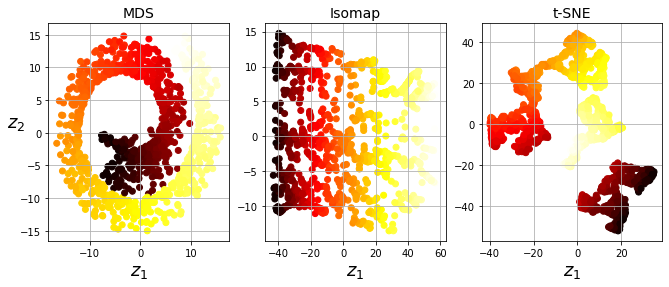

In [71]:
titles = ['MDS', 'Isomap', 't-SNE']

plt.figure(figsize=(11, 4))

for subplot, title, X_reduced in zip((131, 132, 133), titles,
                                     (X_reduced_mds, X_reduced_isomap, X_reduced_tsne)):
    plt.subplot(subplot)
    plt.title(title, fontsize=14)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
    plt.xlabel('$z_1$', fontsize=18)
    if subplot == 131:
        plt.ylabel('$z_2$', fontsize=18, rotation=0)
    plt.grid(True)
    
plt.show()

In [72]:
def learned_parameters(model):
    return [m for m in dir(model) if m.endswith('_') and not m.startswith('_')]

In [73]:
# load MNIST dataset
X_train = mnist['data'][:60000]
y_train = mnist['target'][:60000]

X_test = mnist['data'][60000:]
y_test = mnist['target'][60000:]

In [74]:
# train random forest classifier on MNIST and time it
# evaluate resulting model on test set
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=10, random_state=42)

In [75]:
import time

t0 = time.time()
rnd_clf.fit(X_train, y_train)
t1 = time.time()

In [76]:
print('Training time: {:.2f}s'.format(t1 - t0))

Training time: 5.00s


In [77]:
from sklearn.metrics import accuracy_score

y_pred = rnd_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.9492

In [78]:
# use PCA to reduce dataset dimensionality
# w/ explained variance ratio of 95%
pca = PCA(n_components=0.95)
X_train_reduced = pca.fit_transform(X_train)

In [79]:
# train new random forest classifier on reduced dataset and time it
rnd_clf2 = RandomForestClassifier(n_estimators=10, random_state=42)
t0 = time.time()
rnd_clf2.fit(X_train_reduced, y_train)
t1 = time.time()

print('Training time: {:.2f}s'.format(t1 - t0))

Training time: 10.72s


In [80]:
# evaluate the classifier on the test set
X_test_reduced = pca.transform(X_test)

y_pred = rnd_clf2.predict(X_test_reduced)
accuracy_score(y_test, y_pred)

0.9009

In [82]:
# performance drop is common when reducing dimensionality due to signal loss
# but this loss is quite severe
# ultimately PCA slowed down training and reduced performance
# attempt softmax regression
log_clf = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=42)
t0 = time.time()
log_clf.fit(X_train, y_train)
t1 = time.time()

print('Training time: {:.2f}s'.format(t1 - t0))

Training time: 14.98s


c:\users\sunny\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [83]:
y_pred = log_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.9255

In [84]:
# softmax takes longer to train this dataset and performs worse on the test set
# see how much PCA can help softmax regression
log_clf2 = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=42)
t0 = time.time()
log_clf2.fit(X_train_reduced, y_train)
t1 = time.time()

print('Training time: {:.2f}s'.format(t1 - t0))

Training time: 6.80s


c:\users\sunny\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [85]:
# reducing dimensionality results in speedup
y_pred = log_clf2.predict(X_test_reduced)
accuracy_score(y_test, y_pred)
# slight drop in performance, but within a reason considering
# increased speed of training

0.9201

In [86]:
# use t-SNE to reduce MNIST dataset to 2 dimensions and plot results
# dimensionality reduction on 60k images takes a long time
# use 10k instead
np.random.seed(42)

m = 10000
idx = np.random.permutation(60000)[:m]

X = mnist['data'][idx]
y = mnist['target'][idx]

In [87]:
# use t-SNE tp reduce to 2 dimensions
tsne = TSNE(n_components=2, random_state=42)
X_reduced = tsne.fit_transform(X)

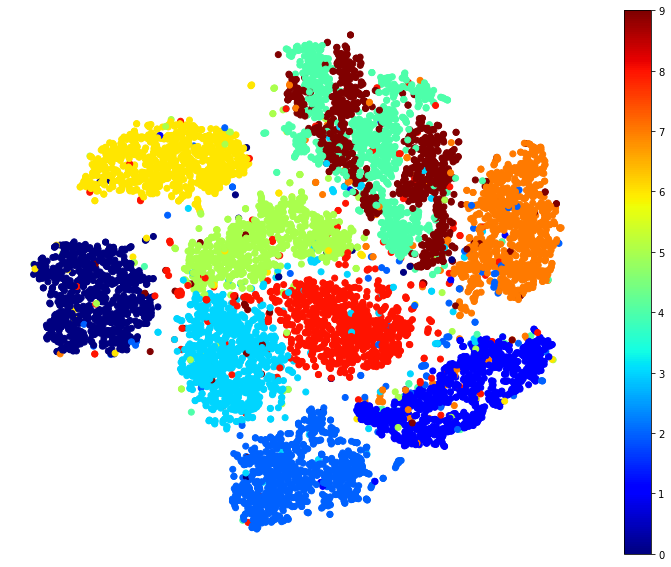

In [88]:
# plot
plt.figure(figsize=(13, 10))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, cmap='jet')
plt.axis('off')
plt.colorbar()

plt.show()

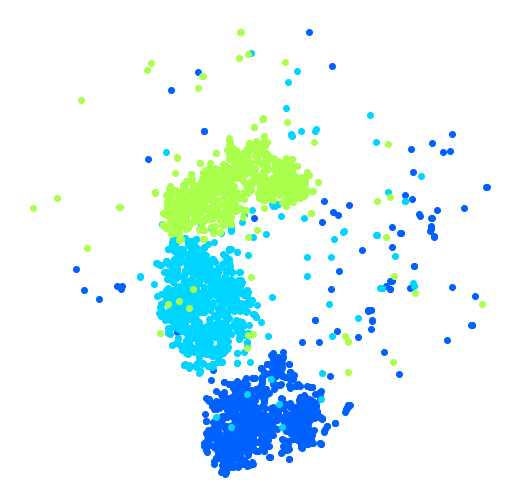

In [89]:
# plot shows which numbers are easily distinguishable from each other
# also tells which numbers are often ared to distinguish
# focus on 3s and 5s as they seem to overlap a lot
plt.figure(figsize=(9, 9))
cmap = mpl.cm.get_cmap('jet')
for digit in (2, 3, 5):
    plt.scatter(X_reduced[y==digit, 0],
                X_reduced[y==digit, 1],
                c=[cmap(digit / 9)])
plt.axis('off')

plt.show()

In [90]:
# produce better image w/ t-SNE
idx = (y==2) | (y==3) | (y==5)
X_subset = X[idx]
y_subset = y[idx]

tsne_subset = TSNE(n_components=2, random_state=42)
X_subset_reduced = tsne_subset.fit_transform(X_subset)

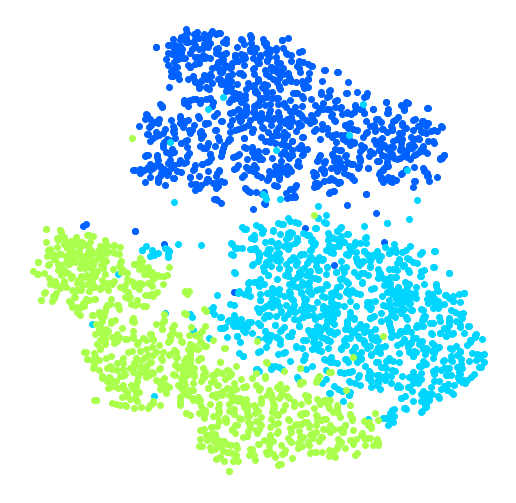

In [93]:
plt.figure(figsize=(9, 9))
for digit in (2, 3, 5):
    plt.scatter(X_subset_reduced[y_subset==digit, 0], 
                X_subset_reduced[y_subset==digit, 1],
                c=[cmap(digit / 9)])
plt.axis('off')

plt.show()
# less overlap in clusters
# a few 3s everywhere and two distinct clusters of 2s and 5s

In [97]:
# draw a scatterplot and write colored digits w/ minimum distance 
# guaranteed between these digits
from sklearn.preprocessing import MinMaxScaler
from matplotlib.offsetbox import AnnotationBbox, OffsetImage

def plot_digits(X, y, min_distance=0.05, images=None, figsize=(13, 10)):
    # scale input features to range from 0 to 1
    X_normalized = MinMaxScaler().fit_transform(X)
    # create list of coordinates of digits plotted so far
    # pretend one is already plotted far away at start
    # to avoid 'if' statements in loop
    neighbors = np.array([[10., 10.]])
    plt.figure(figsize=figsize)
    cmap = mpl.cm.get_cmap('jet')
    digits = np.unique(y)
    for digit in digits:
        plt.scatter(X_normalized[y==digit, 0], X_normalized[y==digit, 1],
                    c=[cmap(digit / 9)])
    plt.axis('off')
    ax = plt.gcf().gca() # get current axes from current figure
    for index, image_coord in enumerate(X_normalized):
        closest_distance = np.linalg.norm(np.array(neighbors) - image_coord, axis=1).min()
        if closest_distance > min_distance:
            neighbors = np.r_[neighbors, [image_coord]]
            if images is None:
                plt.text(image_coord[0], image_coord[1], str(int(y[index])),
                         color=cmap(y[index] / 9), 
                         fontdict={'weight': 'bold', 'size': 16})
            else:
                image = images[index].reshape(28, 28)
                imagebox = AnnotationBbox(OffsetImage(image, cmap='binary'), image_coord)
                ax.add_artist(imagebox)

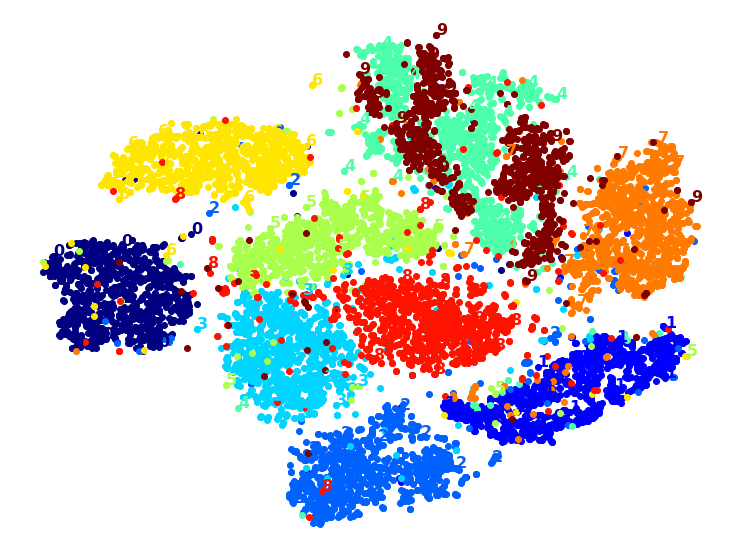

In [98]:
plot_digits(X_reduced, y)

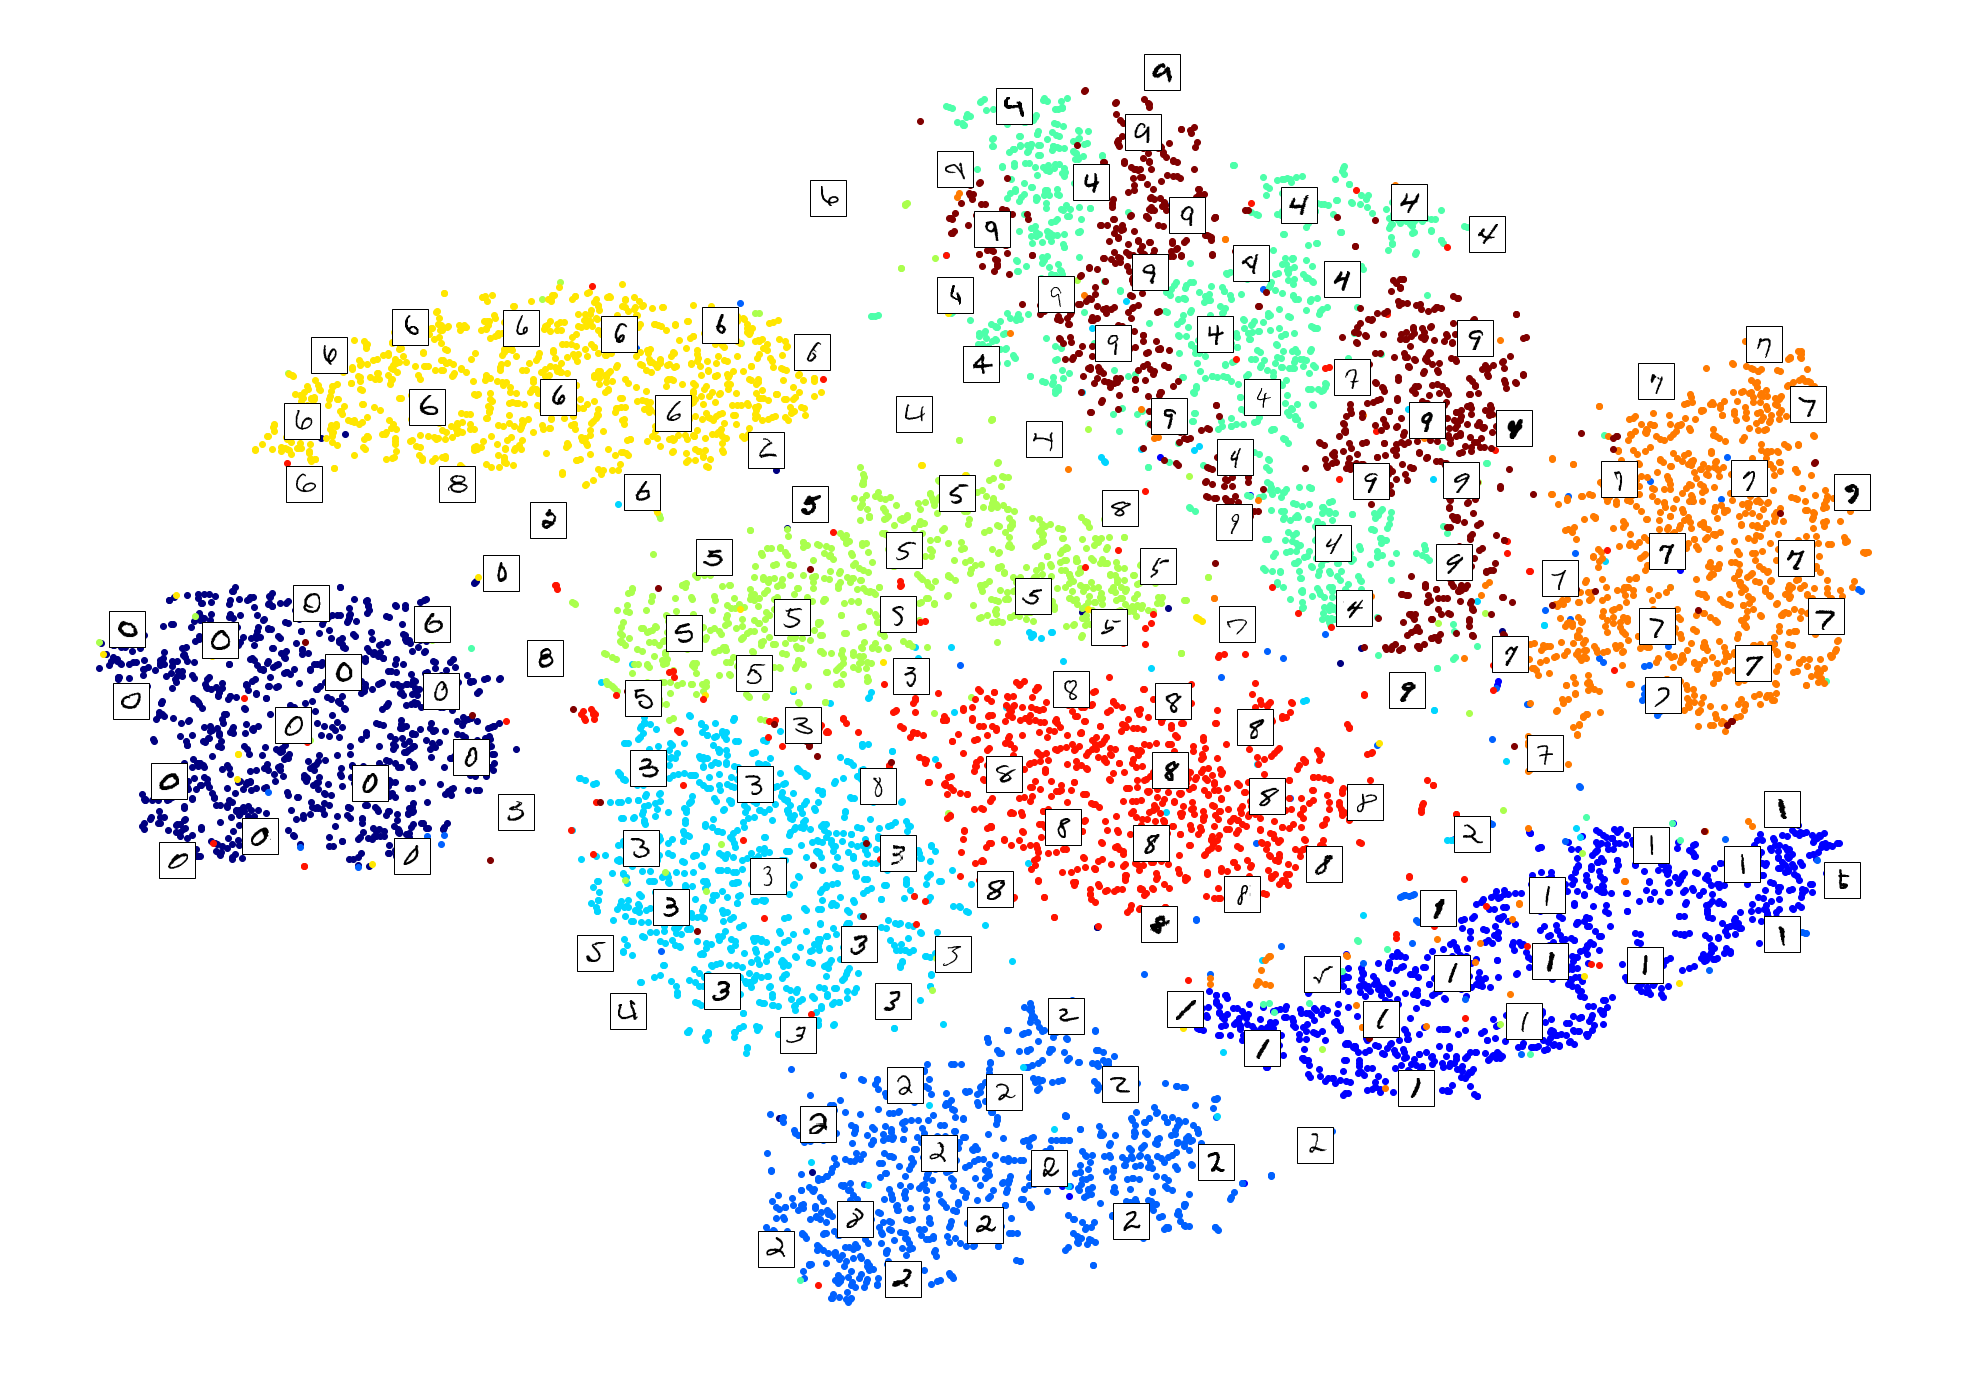

In [99]:
# again but with digit images
plot_digits(X_reduced, y, images=X, figsize=(35, 25))

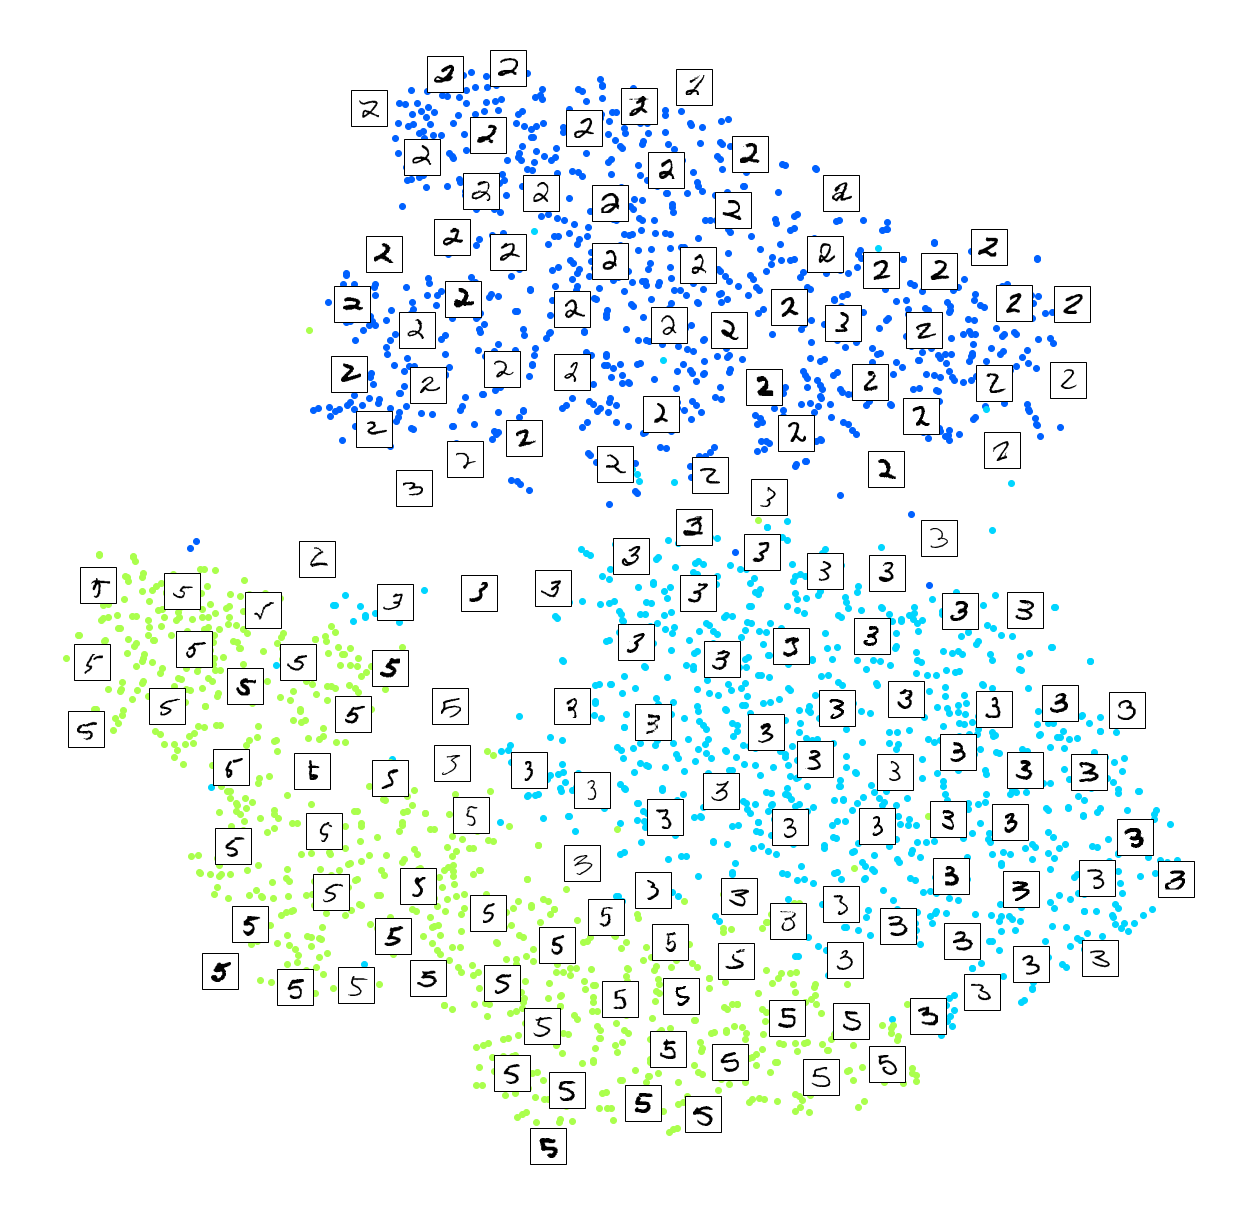

In [100]:
plot_digits(X_subset_reduced, y_subset, images=X_subset, figsize=(22, 22))

PCA time: 0.3s


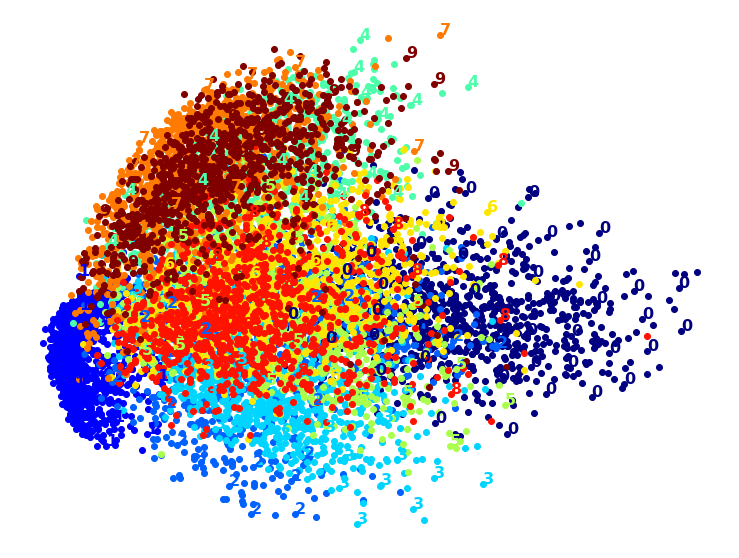

In [101]:
# use PCA, LLE, or MDS and compare resulting visualizations
t0 = time.time()
X_pca_reduced = PCA(n_components=2, random_state=42).fit_transform(X)
t1 = time.time()

print('PCA time: {:.1f}s'.format(t1 - t0))
plot_digits(X_pca_reduced, y)

plt.show()

LLE time: 203.1s


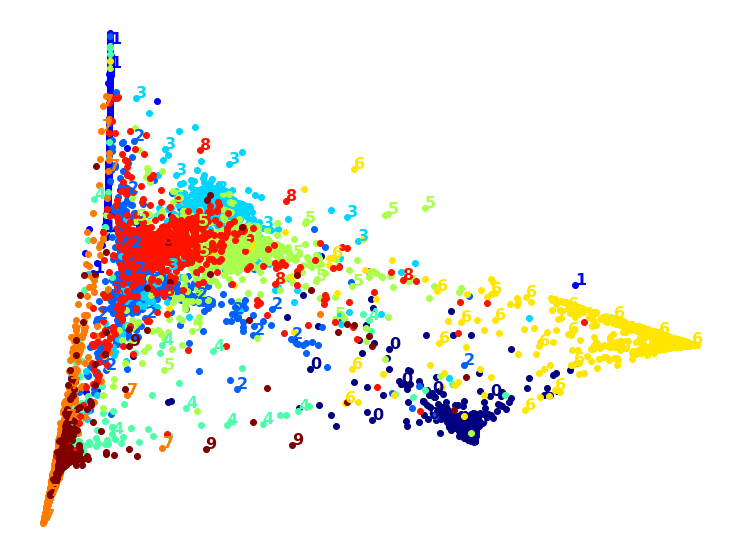

In [102]:
# PCA very fast, but few clusters and a lot of overlap
# try LLE next
t0 = time.time()
X_lle_reduced = LocallyLinearEmbedding(n_components=2, random_state=42).fit_transform(X)
t1 = time.time()

print('LLE time: {:.1f}s'.format(t1 - t0))
plot_digits(X_lle_reduced, y)

plt.show()

PCA + LLE time: 87.0s


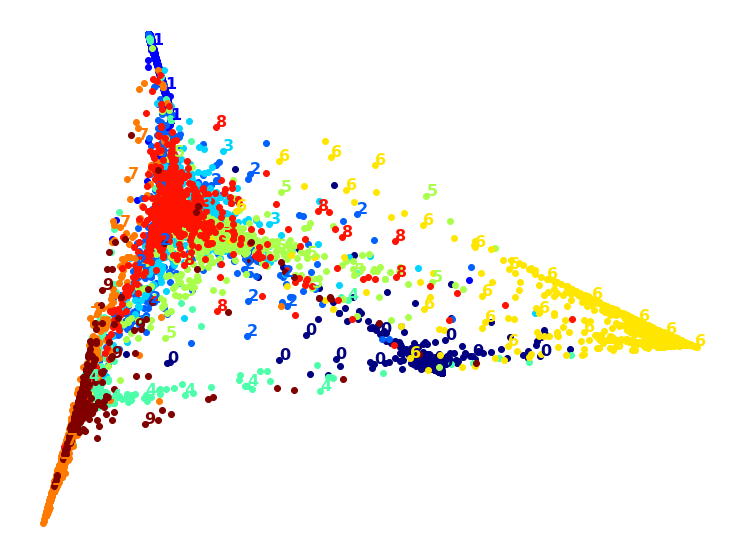

In [103]:
# LLE took a long time and the result is quite bad as well
# try to apply PCA first to preserve 95% of the variance
from sklearn.pipeline import Pipeline

pca_lle = Pipeline([
    ('pca', PCA(n_components=0.95, random_state=42)),
    ('lle', LocallyLinearEmbedding(n_components=2, random_state=42))
])
t0 = time.time()
X_pca_lle_reduced = pca_lle.fit_transform(X)
t1 = time.time()

print('PCA + LLE time: {:.1f}s'.format(t1 - t0))
plot_digits(X_pca_lle_reduced, y)

plt.show()

MDS time: 188.1s (on 2k images instead of 10k images)


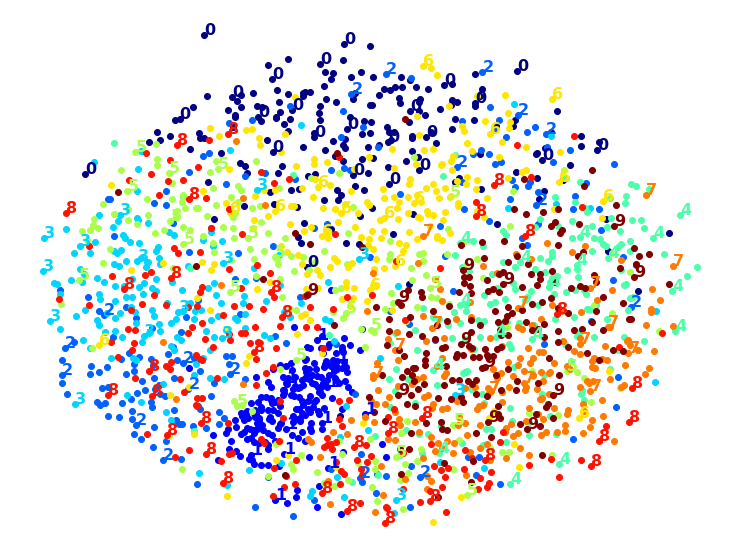

In [104]:
# pretty much the same result, but more than twice as fast
# try MDS but run on 2k images instead of 10k to save time
m = 2000
t0 = time.time()
X_mds_reduced = MDS(n_components=2, random_state=42).fit_transform(X[:m])
t1 = time.time()

print('MDS time: {:.1f}s (on 2k images instead of 10k images)'.format(t1 - t0))
plot_digits(X_mds_reduced, y[:m])

plt.show()

PCA + MDS time: 188.5s (2k images)


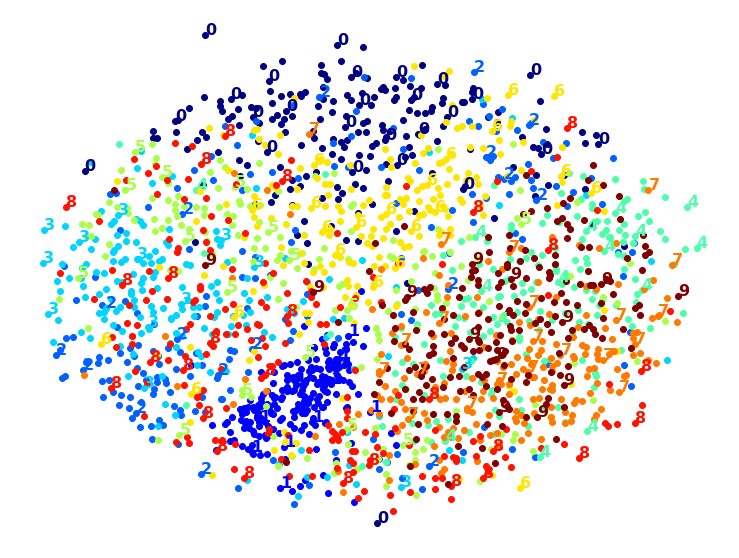

In [105]:
# clusters overlap too much
# try PCA again
pca_mds = Pipeline([
    ('pca', PCA(n_components=0.95, random_state=42)),
    ('mds', MDS(n_components=2, random_state=42))
])
t0 = time.time()
X_pca_mds_reduced = pca_mds.fit_transform(X[:2000])
t1 = time.time()

print('PCA + MDS time: {:.1f}s (2k images)'.format(t1 - t0))
plot_digits(X_pca_mds_reduced, y[:2000])

plt.show()

LDA time: 2.3s


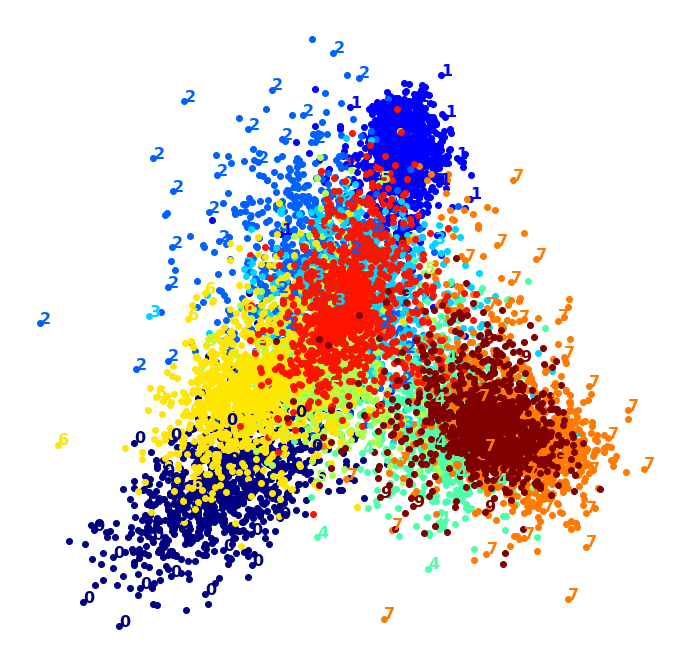

In [106]:
# same result and no increase in speed w/ PCA
# try LDA
t0 = time.time()
X_lda_reduced = LinearDiscriminantAnalysis(n_components=2).fit_transform(X, y)
t1 = time.time()

print('LDA time: {:.1f}s'.format(t1 - t0))
plot_digits(X_lda_reduced, y, figsize=(12, 12))

plt.show()

t-SNE time: 209.0s


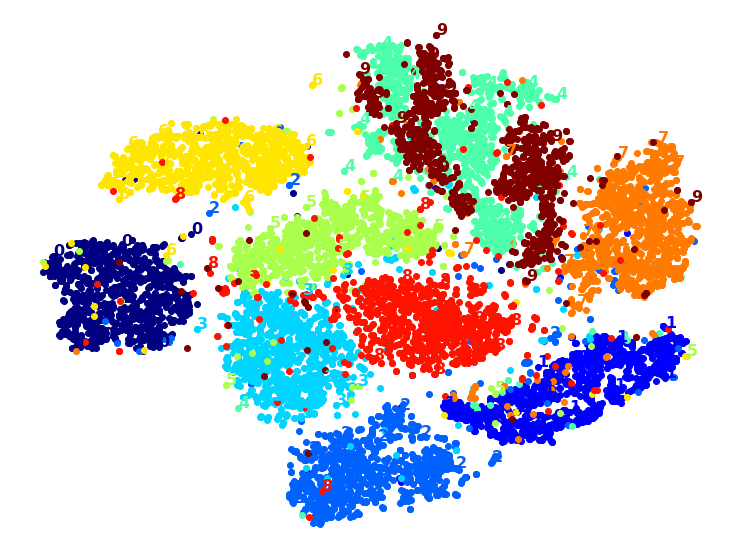

In [107]:
# very fast, but several overlapping clusters
# t-SNE is best so far
t0 = time.time()
X_tsne_reduced = TSNE(n_components=2, random_state=42).fit_transform(X)
t1 = time.time()

print('t-SNE time: {:.1f}s'.format(t1 - t0))
plot_digits(X_tsne_reduced, y)

plt.show()

PCA + t-SNE time: 95.6


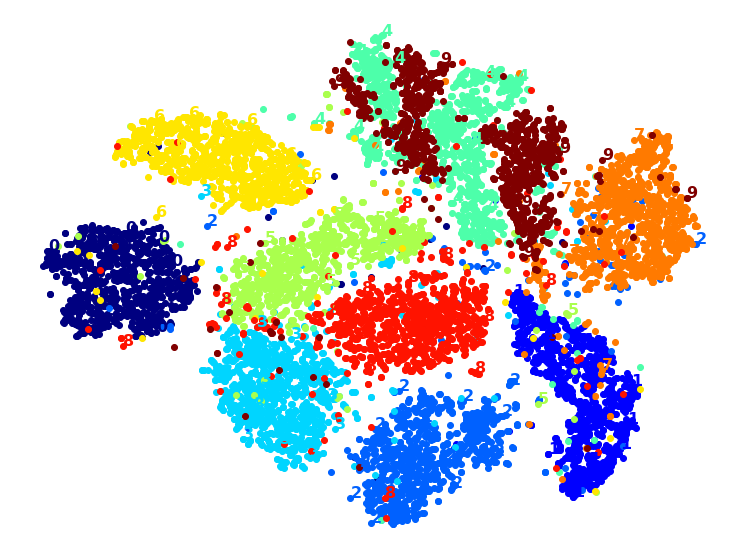

In [109]:
# much slower than LLE, but much faster than MDS and results look good
# attempt PCA to speed it up
pca_tsne = Pipeline([
    ('pca', PCA(n_components=0.95, random_state=42)),
    ('tsne', TSNE(n_components=2, random_state=42))
])
t0 = time.time()
X_pca_tsne_reduced = pca_tsne.fit_transform(X)
t1 = time.time()

print('PCA + t-SNE time: {:.1f}'.format(t1 - t0))
plot_digits(X_pca_tsne_reduced, y)

plt.show()
# PCA increased time by a good amount and retained the result quality